In [1]:
import string
import re
import tensorflow as tf
from pickle import dump
from unicodedata import normalize
import numpy as np
from numpy import array
from numpy.random import rand
from numpy.random import shuffle
import collections
import tensorflow.contrib.legacy_seq2seq as seq2seq
import sys
import copy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pairs = []
all_lines=[]

fptr = open('deu.txt', 'r', encoding='utf-8')
# read all text
lines = fptr.readlines()
#print(lines)
for line in lines :
    #print(line)
    line=line.strip()
    k = line.split('\t')
    
    all_lines.append(line)
    pairs.append(k)
print(pairs[0:2])
print(all_lines[0:2])

[['Hi.', 'Hallo!'], ['Hi.', 'Grüß Gott!']]
['Hi.\tHallo!', 'Hi.\tGrüß Gott!']


In [3]:
max_eng_length = 0
max_ger_length = 0

cleaned = list()
# prepare regex for char filtering
re_print = re.compile('[^%s]' % re.escape(string.printable))
# prepare translation table for removing punctuation
table = str.maketrans('', '', string.punctuation)
for pair in pairs:
    #print(pair[0])
    
        
    clean_pair = list()
    for line in pair:
        # normalize unicode characters
        line = normalize('NFD', line).encode('ascii', 'ignore')
        line = line.decode('UTF-8')
        # tokenize on white space
        line = line.split()
        # convert to lowercase
        line = [word.lower() for word in line]
        # remove punctuation from each token
        line = [word.translate(table) for word in line]
        # remove non-printable chars form each token
        line = [re_print.sub('', w) for w in line]
        # remove tokens with numbers in them
        line = [word for word in line if word.isalpha()]
        # store as string
        clean_pair.append(' '.join(line))
    cleaned.append(clean_pair)
    


In [4]:
print(cleaned[0][0] + " => " + cleaned[0][1])
print(cleaned[1][0] + " => " + cleaned[1][1])

hi => hallo
hi => gru gott


In [5]:
# reduce dataset size
n_sentences = 10000
dataset = cleaned[:n_sentences]
print(dataset[0:2])
print(len(dataset))
print(dataset[0:2][0])
print(dataset[0:2][1])

[['hi', 'hallo'], ['hi', 'gru gott']]
10000
['hi', 'hallo']
['hi', 'gru gott']


In [6]:
print(dataset[0])

['hi', 'hallo']


In [7]:
max_eng_length = 0
max_ger_length = 0

for i in range(len(dataset)) :
    if(len(dataset[i][0]) > max_eng_length) :
        max_eng_length = len(dataset[i][0])
    if(len(dataset[i][1]) > max_ger_length) :
        max_ger_length = len(dataset[i][1])
        
print(max_eng_length)
print(max_ger_length)

15
49


In [8]:
questions = []
labels = []


for i in range(len(dataset)) :
    questions.append(dataset[i][0])
    labels.append(dataset[i][1])
print(questions[1])
print(labels[1])

hi
gru gott


In [9]:
def preprocess_and_save_data(que, lab):
    # Preprocess
    qs = []
    lb = []

    # to the lower case
    for i in que :
        i=i.lower()
        qs.append(i)
    for j in lab :
        j=j.lower()
        lb.append(j)

    # create lookup tables for English and French data
    CODES = {'<PAD>': 0, '<EOS>': 1, '<UNK>': 2, '<GO>': 3 }
    source_vocab = []
    target_vocab = []
    
    for q in qs :
        for j in q.split() :
            source_vocab.append(j)
            
    source_vocab = set(source_vocab)
    
    
    
    for l in lb :
        for k in l.split() :
            target_vocab.append(k)
            
    target_vocab = set(target_vocab)
    #print(target_vocab)
    
    source_vocab_to_int = copy.copy(CODES)
    for v_i, v in enumerate(source_vocab, len(CODES)):
        source_vocab_to_int[v] = v_i


    source_int_to_vocab = {v_i: v for v, v_i in source_vocab_to_int.items()}    
    

 
    target_vocab_to_int = copy.copy(CODES)
    for v_i, v in enumerate(target_vocab, len(CODES)):
        target_vocab_to_int[v] = v_i


    target_int_to_vocab = {v_i: v for v, v_i in target_vocab_to_int.items()}
    
    

    # create list of sentences whose words are represented in index
    
    source_text = []
    target_text = []
    
    for q in qs :
        source_tokens = q.split(" ")
        
        # empty list of converted words to index in the chosen sentence
        source_token_id = []
        
        for index, token in enumerate(source_tokens):
            if (token != ""):
                source_token_id.append(source_vocab_to_int[token])

        source_text.append(source_token_id)        

    for l in lb :
        target_tokens = l.split(" ")
        
        # empty list of converted words to index in the chosen sentence
        target_token_id = []
        
        for index, token in enumerate(target_tokens):
            if (token != ""):
                target_token_id.append(target_vocab_to_int[token])
       
                
        # put <EOS> token at the end of the chosen target sentence
        # this token suggests when to stop creating a sequence
        target_token_id.append(target_vocab_to_int['<EOS>'])        
        
        target_text.append(target_token_id) 
    
    
    
    
    return (source_text, target_text),(source_vocab_to_int, target_vocab_to_int),(source_int_to_vocab, target_int_to_vocab)

In [10]:
(source_int_text, target_int_text), (source_vocab_to_int, target_vocab_to_int), (source_int_to_vocab,target_int_to_vocab) = preprocess_and_save_data(questions,labels)

print(source_int_text[0:2])
print(target_int_text[0:2])
#print(target_int_to_vocab[1])

[[845], [845]]
[[3113, 1], [3454, 463, 1]]


In [110]:
def enc_dec_model_inputs():
    inputs = tf.placeholder(tf.int32, [None, None], name='input')
    targets = tf.placeholder(tf.int32, [None, None], name='targets') 
    
    target_sequence_length = tf.placeholder(tf.int32, [None], name='target_sequence_length')
    max_target_len = tf.reduce_max(target_sequence_length)    
    
    return inputs, targets, target_sequence_length, max_target_len

In [111]:
def hyperparam_inputs():
    lr_rate = tf.placeholder(tf.float32, name='lr_rate')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    
    return lr_rate, keep_prob

In [112]:
def process_decoder_input(target_data, target_vocab_to_int, batch_size):
    """
    Preprocess target data for encoding
    :return: Preprocessed target data
    """
    # get '<GO>' id
    go_id = target_vocab_to_int['<GO>']
    
    after_slice = tf.strided_slice(target_data, [0, 0], [batch_size, -1], [1, 1])
    after_concat = tf.concat( [tf.fill([batch_size, 1], go_id), after_slice], 1)
    
    return after_concat

In [113]:
from tensorflow.contrib.rnn import LSTMCell, LSTMStateTuple

def encoding_layer(rnn_inputs, rnn_size, num_layers, keep_prob, 
                   source_vocab_size, 
                   encoding_embedding_size):
    """
    :return: tuple (RNN output, RNN state)
    """
    embed = tf.contrib.layers.embed_sequence(rnn_inputs, 
                                             vocab_size=source_vocab_size, 
                                             embed_dim=encoding_embedding_size)
    
    stacked_cells = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.LSTMCell(rnn_size), keep_prob) for _ in range(num_layers)])
    
    '''((encoder_fw_outputs,
              encoder_bw_outputs),
             (encoder_fw_state,
              encoder_bw_state)) = (
                tf.nn.bidirectional_dynamic_rnn(cell_fw=stacked_cells,
                                                cell_bw=stacked_cells,
                                                inputs = embed,
                                                time_major=True,
                                                dtype=tf.float32)
                )'''
    
    
    
    encoder_outputs_fw_bw, encoder_last_state_fw_bw = tf.nn.bidirectional_dynamic_rnn(
    cell_fw=stacked_cells,
    cell_bw=stacked_cells,
    inputs=embed,
    dtype=tf.float32,
    time_major=False)
    
    encoder_outputs_fw, encoder_outputs_bw = encoder_outputs_fw_bw
    encoder_outputs = tf.concat([encoder_outputs_fw, encoder_outputs_bw], 2)

    encoder_last_state_fw, encoder_last_state_bw = encoder_last_state_fw_bw

    encoder_last_state_zipped = zip(encoder_last_state_fw, encoder_last_state_bw)
    encoder_last_state_list = [LSTMStateTuple(c=tf.concat([fw.c, bw.c], 1), h=tf.concat([fw.h, bw.h], 1))
                               for fw, bw in encoder_last_state_zipped]
    encoder_last_state = tuple(encoder_last_state_list)

    
    '''print(encoder_fw_outputs)
    print("#############")
    print(encoder_fw_state)
    print("#############")
    print(encoder_bw_state)
    print("#############")
    #enc_state = tf.Variable([64,128])
    #encoder_outputs = tf.concat((encoder_fw_outputs, encoder_bw_outputs), axis = 1)
    print(encoder_outputs)
    print("#############")
    
    #encoder_final_state_c = tf.concat((encoder_fw_state[0].c, encoder_bw_state[0].c), axis = 0)

    #encoder_final_state_h = tf.concat((encoder_fw_state[0].h, encoder_bw_state[0].h), axis = 0)    
    

    print(encoder_final_state_c)
    print("#############")
    
    alternates_c = tf.map_fn(lambda x: (x, x), encoder_final_state_c, dtype=(tf.float32,tf.float32))
    alternates_h = tf.map_fn(lambda x: (x, x), encoder_final_state_h, dtype=(tf.float32,tf.float32))  
    encoder_final_state = LSTMStateTuple(c=encoder_final_state_c,h=encoder_final_state_h)
    print(encoder_final_state)'''
    
    return encoder_outputs,encoder_last_state

In [114]:
def decoding_layer_train(encoder_state, dec_cell, dec_embed_input, 
                         target_sequence_length, max_summary_length, 
                         output_layer, keep_prob):
    """
    Create a training process in decoding layer 
    :return: BasicDecoderOutput containing training logits and sample_id
    """
    dec_cell = tf.contrib.rnn.DropoutWrapper(dec_cell, 
                                             output_keep_prob=keep_prob)
    
    # for only input layer
    helper = tf.contrib.seq2seq.TrainingHelper(dec_embed_input, 
                                               target_sequence_length)
    
    decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell, 
                                              helper, 
                                              encoder_state, 
                                              output_layer)

    # unrolling the decoder layer
    outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(decoder, 
                                                      impute_finished=True, 
                                                      maximum_iterations=max_summary_length)
    return outputs

In [115]:
def decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, start_of_sequence_id,
                         end_of_sequence_id, max_target_sequence_length,
                         vocab_size, output_layer, batch_size, keep_prob):
    """
    Create a inference process in decoding layer 
    :return: BasicDecoderOutput containing inference logits and sample_id
    """
    dec_cell = tf.contrib.rnn.DropoutWrapper(dec_cell, 
                                             output_keep_prob=keep_prob)
    
    helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(dec_embeddings, 
                                                      tf.fill([batch_size], start_of_sequence_id), 
                                                      end_of_sequence_id)
    

    
    decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell, 
                                              helper, 
                                              encoder_state, 
                                              output_layer)
    
    outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(decoder, 
                                                      impute_finished=True, 
                                                      maximum_iterations=max_target_sequence_length)
    return outputs

In [116]:
def decoding_layer(dec_input, encoder_state,
                   target_sequence_length, max_target_sequence_length,
                   rnn_size,
                   num_layers, target_vocab_to_int, target_vocab_size,
                   batch_size, keep_prob, decoding_embedding_size):
    """
    Create decoding layer
    :return: Tuple of (Training BasicDecoderOutput, Inference BasicDecoderOutput)
    """
    target_vocab_size = len(target_vocab_to_int)
    dec_embeddings = tf.Variable(tf.random_uniform([target_vocab_size, decoding_embedding_size]))
    dec_embed_input = tf.nn.embedding_lookup(dec_embeddings, dec_input)
    
    cells = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(2*rnn_size) for _ in range(num_layers)])
    
    with tf.variable_scope("decode"):
        output_layer = tf.layers.Dense(target_vocab_size)
        train_output = decoding_layer_train(encoder_state, 
                                            cells, 
                                            dec_embed_input, 
                                            target_sequence_length, 
                                            max_target_sequence_length, 
                                            output_layer, 
                                            keep_prob)

    with tf.variable_scope("decode", reuse=True):
        infer_output = decoding_layer_infer(encoder_state, 
                                            cells, 
                                            dec_embeddings, 
                                            target_vocab_to_int['<GO>'], 
                                            target_vocab_to_int['<EOS>'], 
                                            max_target_sequence_length, 
                                            target_vocab_size, 
                                            output_layer,
                                            batch_size,
                                            keep_prob)

    return (train_output, infer_output)

In [117]:
def seq2seq_model(input_data, target_data, keep_prob, batch_size,
                  target_sequence_length,
                  max_target_sentence_length,
                  source_vocab_size, target_vocab_size,
                  enc_embedding_size, dec_embedding_size,
                  rnn_size, num_layers, target_vocab_to_int):
    """
    Build the Sequence-to-Sequence model
    :return: Tuple of (Training BasicDecoderOutput, Inference BasicDecoderOutput)
    """
    enc_outputs, enc_states = encoding_layer(input_data, 
                                             rnn_size, 
                                             num_layers, 
                                             keep_prob, 
                                             source_vocab_size, 
                                             enc_embedding_size)
    
    dec_input = process_decoder_input(target_data, 
                                      target_vocab_to_int, 
                                      batch_size)
    
    train_output, infer_output = decoding_layer(dec_input,
                                               enc_states, 
                                               target_sequence_length, 
                                               max_target_sentence_length,
                                               rnn_size,
                                              num_layers,
                                              target_vocab_to_int,
                                              target_vocab_size,
                                              batch_size,
                                              keep_prob,
                                              dec_embedding_size)
    
    
    '''print(dec_input)
    print("************")
    print(enc_states)
    print("************")'''
    
    return train_output, infer_output

In [118]:
display_step = 30

epochs = 2
batch_size = 64

rnn_size = 128
num_layers = 3

encoding_embedding_size = 100
decoding_embedding_size = 100

learning_rate = 0.001
keep_probability = 0.5
max_grad_norm = 5

In [119]:
save_path = 'checkpoints/ayan'
(source_int_text, target_int_text), (source_vocab_to_int, target_vocab_to_int), (source_int_to_vocab,target_int_to_vocab) = preprocess_and_save_data(questions,labels)
max_target_sentence_length = max([len(sentence) for sentence in source_int_text])

train_graph = tf.Graph()
with train_graph.as_default():
    input_data, targets, target_sequence_length, max_target_sequence_length = enc_dec_model_inputs()
    lr, keep_prob = hyperparam_inputs()
    
    train_logits, inference_logits = seq2seq_model(tf.reverse(input_data, [-1]),
                                                   targets,
                                                   keep_prob,
                                                   batch_size,
                                                   target_sequence_length,
                                                   max_target_sequence_length,
                                                   len(source_vocab_to_int),
                                                   len(target_vocab_to_int),
                                                   encoding_embedding_size,
                                                   decoding_embedding_size,
                                                   rnn_size,
                                                   num_layers,
                                                   target_vocab_to_int)
    
    training_logits = tf.identity(train_logits.rnn_output, name='logits')
    inference_logits = tf.identity(inference_logits.sample_id, name='predictions')

    # https://www.tensorflow.org/api_docs/python/tf/sequence_mask
    # - Returns a mask tensor representing the first N positions of each cell.
    masks = tf.sequence_mask(target_sequence_length, max_target_sequence_length, dtype=tf.float32, name='masks')

    with tf.name_scope("optimization"):
        # Loss function - weighted softmax cross entropy
        cost = tf.contrib.seq2seq.sequence_loss(
            training_logits,
            targets,
            masks)

        # Optimizer
        optimizer = tf.train.AdamOptimizer(lr)

        
        
        '''tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(tf.gradients(cost, tvars),max_grad_norm)'''
        # Gradient Clipping
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)


In [120]:
def pad_sentence_batch(sentence_batch, pad_int):
    """Pad sentences with <PAD> so that each sentence of a batch has the same length"""
    max_sentence = max([len(sentence) for sentence in sentence_batch])
    return [sentence + [pad_int] * (max_sentence - len(sentence)) for sentence in sentence_batch]


def get_batches(sources, targets, batch_size, source_pad_int, target_pad_int):
    """Batch targets, sources, and the lengths of their sentences together"""
    for batch_i in range(0, len(sources)//batch_size):
        start_i = batch_i * batch_size

        # Slice the right amount for the batch
        sources_batch = sources[start_i:start_i + batch_size]
        targets_batch = targets[start_i:start_i + batch_size]

        # Pad
        pad_sources_batch = np.array(pad_sentence_batch(sources_batch, source_pad_int))
        pad_targets_batch = np.array(pad_sentence_batch(targets_batch, target_pad_int))

        # Need the lengths for the _lengths parameters
        pad_targets_lengths = []
        for target in pad_targets_batch:
            pad_targets_lengths.append(len(target))

        pad_source_lengths = []
        for source in pad_sources_batch:
            pad_source_lengths.append(len(source))

        yield pad_sources_batch, pad_targets_batch, pad_source_lengths, pad_targets_lengths

In [121]:
def get_accuracy(target, logits):
    """
    Calculate accuracy
    """
    max_seq = max(target.shape[1], logits.shape[1])
    if max_seq - target.shape[1]:
        target = np.pad(
            target,
            [(0,0),(0,max_seq - target.shape[1])],
            'constant')
    if max_seq - logits.shape[1]:
        logits = np.pad(
            logits,
            [(0,0),(0,max_seq - logits.shape[1])],
            'constant')

    return np.mean(np.equal(target, logits))

In [122]:
# Split data to training and validation sets
train_source = source_int_text[batch_size:]
train_target = target_int_text[batch_size:]
valid_source = source_int_text[:batch_size]
valid_target = target_int_text[:batch_size]
(valid_sources_batch, valid_targets_batch, valid_sources_lengths, valid_targets_lengths ) = next(get_batches(valid_source,
                                                                                                             valid_target,
                                                                                                             batch_size,
                                                                                                             source_vocab_to_int['<PAD>'],
                                                                                                             target_vocab_to_int['<PAD>']))               



In [123]:
with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess,coord=coord)
    
    loss_track=[]
    grad_track = []
    
    for epoch_i in range(epochs):
        for batch_i, (source_batch, target_batch, sources_lengths, targets_lengths) in enumerate(
                get_batches(train_source, train_target, batch_size,
                            source_vocab_to_int['<PAD>'],
                            target_vocab_to_int['<PAD>'])):

            #print(target_batch)
            #print(epoch_i)
            _, loss = sess.run(
                [train_op, cost],
                {input_data: source_batch,
                 targets: target_batch,
                 lr: learning_rate,
                 target_sequence_length: targets_lengths,
                 keep_prob: keep_probability})
            loss_track.append(loss)
        
            



            if batch_i % display_step == 0 and batch_i > 0:
                batch_train_logits = sess.run(
                    inference_logits,
                    {input_data: source_batch,
                     target_sequence_length: targets_lengths,
                     keep_prob: 1.0})

                batch_valid_logits = sess.run(
                    inference_logits,
                    {input_data: valid_sources_batch,
                     target_sequence_length: valid_targets_lengths,
                     keep_prob: 1.0})

                train_acc = get_accuracy(target_batch, batch_train_logits)
                valid_acc = get_accuracy(valid_targets_batch, batch_valid_logits)

                print('Epoch {:>3} Batch {:>4}/{} - Train Accuracy: {:>6.4f}, Validation Accuracy: {:>6.4f}, Loss: {:>6.4f}'
                      .format(epoch_i, batch_i, len(source_int_text) // batch_size, train_acc, valid_acc, loss))

    coord.request_stop()
    coord.join(threads)               
                
    # Save Model
    saver = tf.train.Saver()
    saver.save(sess, save_path)
    print('Model Trained and Saved')
    
    sess.close()

Epoch   0 Batch   30/156 - Train Accuracy: 0.3229, Validation Accuracy: 0.4844, Loss: 4.4510
Epoch   0 Batch   60/156 - Train Accuracy: 0.2578, Validation Accuracy: 0.4844, Loss: 4.5386
Epoch   0 Batch   90/156 - Train Accuracy: 0.3571, Validation Accuracy: 0.4844, Loss: 3.9698
Epoch   0 Batch  120/156 - Train Accuracy: 0.5039, Validation Accuracy: 0.5391, Loss: 3.5375
Epoch   0 Batch  150/156 - Train Accuracy: 0.3504, Validation Accuracy: 0.5703, Loss: 4.2354
Epoch   1 Batch   30/156 - Train Accuracy: 0.3281, Validation Accuracy: 0.5755, Loss: 3.7231
Epoch   1 Batch   60/156 - Train Accuracy: 0.3255, Validation Accuracy: 0.5208, Loss: 3.9825
Epoch   1 Batch   90/156 - Train Accuracy: 0.4196, Validation Accuracy: 0.5208, Loss: 3.6435
Epoch   1 Batch  120/156 - Train Accuracy: 0.4180, Validation Accuracy: 0.5286, Loss: 3.3001
Epoch   1 Batch  150/156 - Train Accuracy: 0.3996, Validation Accuracy: 0.5599, Loss: 4.0569
Model Trained and Saved


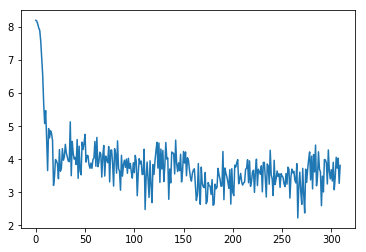

In [124]:
plt.plot(loss_track)

In [125]:
import pickle
def save_params(params):
    with open('params-du-en-bi.p', 'wb') as out_file:
        pickle.dump(params, out_file)


def load_params():
    with open('params-du-en-bi.p', mode='rb') as in_file:
        return pickle.load(in_file)

In [126]:
save_params(save_path)

In [127]:
load_path = load_params()

In [128]:
def sentence_to_seq(sentence, vocab_to_int):
    results = []
    for word in sentence.split(" "):
        if word in vocab_to_int:
            results.append(vocab_to_int[word])
        else:
            results.append(vocab_to_int['<UNK>'])
            
    return results

translate_sentence = 'how are you today?'

translate_sentence = sentence_to_seq(translate_sentence, source_vocab_to_int)

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(load_path + '.meta')
    loader.restore(sess, load_path)

    input_data = loaded_graph.get_tensor_by_name('input:0')
    logits = loaded_graph.get_tensor_by_name('predictions:0')
    target_sequence_length = loaded_graph.get_tensor_by_name('target_sequence_length:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')

    translate_logits = sess.run(logits, {input_data: [translate_sentence]*batch_size,
                                         target_sequence_length: [len(translate_sentence)*2]*batch_size,
                                         keep_prob: 1.0})[0]

print('Input')
print('  Word Ids:      {}'.format([i for i in translate_sentence]))
print('  English Words: {}'.format([source_int_to_vocab[i] for i in translate_sentence]))

print('\nPrediction')
print('  Word Ids:      {}'.format([i for i in translate_logits]))
print('  German Words: {}'.format(" ".join([target_int_to_vocab[i] for i in translate_logits])))


INFO:tensorflow:Restoring parameters from checkpoints/ayan
Input
  Word Ids:      [1069, 1197, 1643, 2]
  English Words: ['how', 'are', 'you', '<UNK>']

Prediction
  Word Ids:      [1526, 296, 1]
  German Words: ich ist <EOS>
